# Part B: Regression Problem

# Use [markdown](https://www.markdownguide.org/basic-syntax/) to label each (sub)question neatly.

This notebook serves as your report. All your answers should be presented within it. 

You can submit multiple notebooks (e.g. 1 notebook per part / question).

Before submission, remember to tidy up the notebook and retain only relevant parts.

In [1]:
# Setting the seed here is sufficient. 
# If you don't plan to use these starter code, make sure you add this cell.

SEED = 42

import os
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

import random 
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Normalization, StringLookup, IntegerLookup

In [3]:
import pandas as pd

In [4]:
# df = pd.read_csv('./hdb_price_prediction.csv')
# df

In [5]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:

    from google.colab import drive
    %cd '/content/drive/MyDrive/y4s1/cz4042 nn/assignment1/'

In [6]:
df = pd.read_csv('hdb_price_prediction.csv')
df

,month,year,full_address,nearest_stn,dist_to_nearest_stn,dist_to_dhoby,degree_centrality,eigenvector_centrality,flat_model_type,remaining_lease_years,floor_area_sqm,storey_range,resale_price
0,1,2017,406 ANG MO KIO AVENUE 10,Ang Mo Kio,1.007264,7.006044,0.016807,0.006243,"2 ROOM, Improved",61.333333,44.0,10 TO 12,232000.0
1,1,2017,108 ANG MO KIO AVENUE 4,Ang Mo Kio,1.271389,7.983837,0.016807,0.006243,"3 ROOM, New Generation",60.583333,67.0,01 TO 03,250000.0
2,1,2017,602 ANG MO KIO AVENUE 5,Yio Chu Kang,1.069743,9.090700,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,262000.0
3,1,2017,465 ANG MO KIO AVENUE 10,Ang Mo Kio,0.946890,7.519889,0.016807,0.006243,"3 ROOM, New Generation",62.083333,68.0,04 TO 06,265000.0
4,1,2017,601 ANG MO KIO AVENUE 5,Yio Chu Kang,1.092551,9.130489,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,265000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
133407,6,2022,877 YISHUN STREET 81,Khatib,0.475885,12.738721,0.016807,0.000968,"EXECUTIVE, Maisonette",64.583333,145.0,07 TO 09,810000.0
133408,1,2022,633 YISHUN STREET 61,Khatib,0.774113,13.229106,0.016807,0.000968,"MULTI-GENERATION, Multi Generation",65.000000,164.0,04 TO 06,785000.0
133409,2,2022,633 YISHUN STREET 61,Khatib,0.774113,13.229106,0.016807,0.000968,"MULTI-GENERATION, Multi Generation",64.916667,171.0,04 TO 06,842000.0
133410,2,2022,632 YISHUN STREET 61,Khatib,0.700595,13.222912,0.016807,0.000968,"MULTI-GENERATION, Multi Generation",64.750000,164.0,10 TO 12,845000.0


In [7]:
# The functions in this cell are adapted from https://keras.io/examples/structured_data/structured_data_classification_from_scratch/
# It is the same link as the one mentioned in the question paper (Q1b)

def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("resale_price")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature


def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="binary") # NOTE: as mentioned in the question paper, this actually does one-hot encoding. You could replace 'binary' with 'one_hot' if you wish to.

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature


In [8]:
from keras import backend as K

def r2(y_true, y_pred): 
    '''
    # Obtained from https://jmlb.github.io/ml/2017/03/20/CoeffDetermination_CustomMetric4Keras/
    # TODO: you have to find out how to use it in your code
    '''
    SS_res = K.sum(K.square( y_true - y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

## Question 1

Real world datasets often have a mix of numeric and categorical features – this dataset is one such example. To build models on such data, categorical features have to be encoded. Also, before applying neural networks, it is a good practice to try simpler machine learning algorithms first.

For all models in Part B of the assignment, the following features should be used: 
*   Numeric features: dist_to_nearest_stn, dist_to_dhoby, degree_centrality, eigenvector_centrality, remaining_lease_years, floor_area_sqm
*   Categorical features: month, flat_model_type, storey_range

One-hot encoding should be applied on categorical features. 
Standardisation should be performed on numeric features.

### Part a

Divide the dataset (‘HDB_price_prediction.csv’) into train and test sets by using entries from year 2020 and before as training data (with the remaining data from year 2021 and 2022 used as test data).

Why is this done instead of using random train/test splits?

In [9]:
# Split data

train_dataframe = df[df['year'] <= 2020] 
val_dataframe = df[df['year'] > 2020] 

train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)

train_ds = train_ds.batch(256)
val_ds = val_ds.batch(256)

In [10]:
# why is this done instead of using random train/test splits


### Part b

A team of data scientists has implemented a linear regression model via Scikit-learn. They obtained a test R2 value of 0.627 and happily shared with you that their model only took a few seconds to train. They suggest you to try out an equivalent deep learning model to see if you get a similar result. Recall that a linear regression model is equivalent to a neural network with only 1 Dense layer (i.e. no hidden layer) with linear activation and 1 output node.

However, modelling such a mix of feature types with neural networks requires some changes to the input layer. Implement this neural network by following this tutorial from the Keras documentation which guides you through the process of using the Functional API to do so. After encoding / standardisation, the features should be concatenated. Your architecture should resemble the figure shown in Appendix A.

In [11]:
df.columns

Index(['month', 'year', 'full_address', 'nearest_stn', 'dist_to_nearest_stn',
       'dist_to_dhoby', 'degree_centrality', 'eigenvector_centrality',
       'flat_model_type', 'remaining_lease_years', 'floor_area_sqm',
       'storey_range', 'resale_price'],
      dtype='object')

In [12]:
# Categorical features encoded as integers
month = keras.Input(shape=(1,), name="month", dtype="int64")
month_encoded = encode_categorical_feature(month, "month", train_ds, False)

# Categorical feature encoded as string
flat_model_type = keras.Input(shape=(1,), name="flat_model_type", dtype="string")
flat_model_type_encoded = encode_categorical_feature(flat_model_type, "flat_model_type", train_ds, True)

storey_range = keras.Input(shape=(1,), name="storey_range", dtype="string")
storey_range_encoded = encode_categorical_feature(storey_range, "storey_range", train_ds, True)

# Numerical features
floor_area_sqm = keras.Input(shape=(1,), name="floor_area_sqm")
floor_area_sqm_encoded = encode_numerical_feature(floor_area_sqm, "floor_area_sqm", train_ds)

remaining_lease_years = keras.Input(shape=(1,), name="remaining_lease_years")
remaining_lease_years_encoded = encode_numerical_feature(remaining_lease_years, "remaining_lease_years", train_ds)

eigenvector_centrality = keras.Input(shape=(1,), name="eigenvector_centrality")
eigenvector_centrality_encoded = encode_numerical_feature(eigenvector_centrality, "eigenvector_centrality", train_ds) 

degree_centrality = keras.Input(shape=(1,), name="degree_centrality")
degree_centrality_encoded = encode_numerical_feature(degree_centrality, "degree_centrality", train_ds)

dist_to_dhoby = keras.Input(shape=(1,), name="dist_to_dhoby")
dist_to_dhoby_encoded = encode_numerical_feature(dist_to_dhoby, "dist_to_dhoby", train_ds)

dist_to_nearest_stn = keras.Input(shape=(1,), name="dist_to_nearest_stn")
dist_to_nearest_stn_encoded = encode_numerical_feature(dist_to_nearest_stn, "dist_to_nearest_stn", train_ds)

all_inputs = [
    dist_to_nearest_stn,
    dist_to_dhoby,
    degree_centrality,
    eigenvector_centrality,
    remaining_lease_years,
    floor_area_sqm,
    month,
    flat_model_type,
    storey_range
]

all_features = layers.concatenate(
    [
        month_encoded,
        flat_model_type_encoded,
        floor_area_sqm_encoded,
        storey_range_encoded,
        remaining_lease_years_encoded,
        eigenvector_centrality_encoded,
        degree_centrality_encoded,
        dist_to_dhoby_encoded,
        dist_to_nearest_stn_encoded        
    ]
)

In [13]:
# define the model
output = layers.Dense(1, activation="linear")(all_features)
model = keras.Model(all_inputs, output)

In [14]:
# plot the model
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


### Part c

The team suggests you to train the model for 50 epochs using mini-batch gradient descent with batch size = 256, Adam optimiser (with a default learning rate of 𝛼 = 0.001) and mean square error as cost function. However, you find that your results are far off from their model. Change the optimiser to SGD (with default learning rate of 𝛼 = 0.01) and observe how the problem gets fixed. Report the test R2 value and explain why the change to SGD fixes the problem faced when using Adam optimiser. (Hint: Look carefully at how Adam is implemented and see how SGD is different.)

In [15]:
# adam optimizer
adam_opt = tf.keras.optimizers.Adam(learning_rate=0.001)

no_epochs = 50
batch_size = 256

In [16]:
# define the model
output = layers.Dense(1, activation="linear")(all_features)
model = keras.Model(all_inputs, output)

# compile the model
model.compile(optimizer=adam_opt,
              loss='mse', 
              metrics=[r2])

# fit the model
history = model.fit(train_ds, 
                    epochs=no_epochs, 
                    batch_size=batch_size,
                    verbose = 2,
                    validation_data=val_ds)

Epoch 1/50


C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\functional.py:637: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


342/342 - 3s - loss: 219585888256.0000 - r2: -8.3474e+00 - val_loss: 301486768128.0000 - val_r2: -1.0083e+01 - 3s/epoch - 9ms/step
Epoch 2/50
342/342 - 2s - loss: 219584561152.0000 - r2: -8.3520e+00 - val_loss: 301485096960.0000 - val_r2: -1.0072e+01 - 2s/epoch - 6ms/step
Epoch 3/50
342/342 - 2s - loss: 219583217664.0000 - r2: -8.3501e+00 - val_loss: 301483491328.0000 - val_r2: -1.0103e+01 - 2s/epoch - 6ms/step
Epoch 4/50
342/342 - 2s - loss: 219581857792.0000 - r2: -8.3437e+00 - val_loss: 301481984000.0000 - val_r2: -1.0080e+01 - 2s/epoch - 6ms/step
Epoch 5/50
342/342 - 2s - loss: 219580628992.0000 - r2: -8.3458e+00 - val_loss: 301480345600.0000 - val_r2: -1.0121e+01 - 2s/epoch - 6ms/step
Epoch 6/50
342/342 - 2s - loss: 219579383808.0000 - r2: -8.3513e+00 - val_loss: 301478903808.0000 - val_r2: -1.0084e+01 - 2s/epoch - 6ms/step
Epoch 7/50
342/342 - 2s - loss: 219578007552.0000 - r2: -8.3379e+00 - val_loss: 301477265408.0000 - val_r2: -1.0079e+01 - 2s/epoch - 6ms/step
Epoch 8/50
342/34

In [17]:
evaluate_adam = model.evaluate(val_ds, verbose =2)

print("------- Evaluation of Adam optimiser -------")
print("Mean Squared Error: " + str(evaluate_adam[0]))
print("R Squared Error: " + str(evaluate_adam[1]))

180/180 - 1s - loss: 301409697792.0000 - r2: -1.0089e+01 - 971ms/epoch - 5ms/step
------- Evaluation of Adam optimiser -------
Mean Squared Error: 301409697792.0
R Squared Error: -10.088726043701172


In [18]:
# sgd optimizer
sgd_opt = tf.keras.optimizers.SGD(learning_rate=0.001)

no_epochs = 50
batch_size = 256

In [19]:
# define the model
output = layers.Dense(1, activation="linear")(all_features)
model = keras.Model(all_inputs, output)

# compile the model
model.compile(optimizer=sgd_opt,
              loss='mse', 
              metrics=[r2])

# fit the model
history = model.fit(train_ds, 
                    epochs=no_epochs, 
                    batch_size=batch_size,
                    verbose = 2,
                    validation_data=val_ds)

Epoch 1/50
342/342 - 4s - loss: 105362341888.0000 - r2: -3.4847e+00 - val_loss: 79115247616.0000 - val_r2: -1.9028e+00 - 4s/epoch - 11ms/step
Epoch 2/50
342/342 - 3s - loss: 23966013440.0000 - r2: -1.3541e-02 - val_loss: 33178230784.0000 - val_r2: -2.1243e-01 - 3s/epoch - 8ms/step
Epoch 3/50
342/342 - 3s - loss: 10475787264.0000 - r2: 0.5588 - val_loss: 21229615104.0000 - val_r2: 0.2245 - 3s/epoch - 8ms/step
Epoch 4/50
342/342 - 3s - loss: 7811955712.0000 - r2: 0.6699 - val_loss: 17264797696.0000 - val_r2: 0.3698 - 3s/epoch - 9ms/step
Epoch 5/50
342/342 - 3s - loss: 7028672512.0000 - r2: 0.7031 - val_loss: 15663082496.0000 - val_r2: 0.4281 - 3s/epoch - 8ms/step
Epoch 6/50
342/342 - 3s - loss: 6648599552.0000 - r2: 0.7195 - val_loss: 14880990208.0000 - val_r2: 0.4574 - 3s/epoch - 9ms/step
Epoch 7/50
342/342 - 3s - loss: 6396240384.0000 - r2: 0.7292 - val_loss: 14443913216.0000 - val_r2: 0.4733 - 3s/epoch - 8ms/step
Epoch 8/50
342/342 - 3s - loss: 6205049344.0000 - r2: 0.7370 - val_loss:

In [20]:
evaluate_sgd = model.evaluate(val_ds, verbose =2)

print("------- Evaluation of SGD optimiser -------")
print("Mean Squared Error: " + str(evaluate_sgd[0]))
print("R Squared Error: " + str(evaluate_sgd[1]))

180/180 - 1s - loss: 11907702784.0000 - r2: 0.5644 - 990ms/epoch - 5ms/step
------- Evaluation of SGD optimiser -------
Mean Squared Error: 11907702784.0
R Squared Error: 0.564415454864502


In [21]:
# report test r^2 value
print("R Squared Error (Adam Optimizer): " + str(evaluate_adam[1]))
print("R Squared Error (SGD Optimizer): " + str(evaluate_sgd[1]))

# explain why change to sgd fixes problem faced when using adam optimizer


R Squared Error (Adam Optimizer): -10.088726043701172
R Squared Error (SGD Optimizer): 0.564415454864502


### Part d

Add 1 hidden layer (10 units) to the architecture in Q1c and train it with the same configuration as in Q1c (i.e. with Adam) except that the learning rate is increased to 0.08. Report the test R^2 value.

In [22]:
# adam optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.08)

no_epochs = 50
batch_size = 256

In [23]:
# define the model
x = layers.Dense(10, activation="relu")(all_features)
output = layers.Dense(1, activation="linear")(x)

model = keras.Model(all_inputs, output)

# compile the model
model.compile(optimizer=opt,
              loss='mse', 
              metrics=[r2])

# fit the model
history = model.fit(train_ds, 
                    epochs=no_epochs, 
                    batch_size=batch_size,
                    verbose = 2,
                    validation_data=val_ds)

Epoch 1/50
342/342 - 4s - loss: 207019835392.0000 - r2: -7.8079e+00 - val_loss: 254408441856.0000 - val_r2: -8.3368e+00 - 4s/epoch - 11ms/step
Epoch 2/50
342/342 - 3s - loss: 136503885824.0000 - r2: -4.8137e+00 - val_loss: 145572216832.0000 - val_r2: -4.3419e+00 - 3s/epoch - 8ms/step
Epoch 3/50
342/342 - 3s - loss: 56194830336.0000 - r2: -1.3895e+00 - val_loss: 59504099328.0000 - val_r2: -1.1821e+00 - 3s/epoch - 8ms/step
Epoch 4/50
342/342 - 3s - loss: 15815080960.0000 - r2: 0.3302 - val_loss: 23683538944.0000 - val_r2: 0.1338 - 3s/epoch - 10ms/step
Epoch 5/50
342/342 - 4s - loss: 6442761728.0000 - r2: 0.7280 - val_loss: 14698857472.0000 - val_r2: 0.4635 - 4s/epoch - 10ms/step
Epoch 6/50
342/342 - 3s - loss: 5273347072.0000 - r2: 0.7771 - val_loss: 12822839296.0000 - val_r2: 0.5315 - 3s/epoch - 9ms/step
Epoch 7/50
342/342 - 3s - loss: 4954203136.0000 - r2: 0.7905 - val_loss: 12347603968.0000 - val_r2: 0.5493 - 3s/epoch - 8ms/step
Epoch 8/50
342/342 - 3s - loss: 4714177536.0000 - r2: 0.

In [24]:
evaluate_model = model.evaluate(val_ds, verbose =2)

print("Mean Squared Error: " + str(evaluate_model[0]))
print("R Squared Error: " + str(evaluate_model[1]))

180/180 - 1s - loss: 9357888512.0000 - r2: 0.6564 - 966ms/epoch - 5ms/step
Mean Squared Error: 9357888512.0
R Squared Error: 0.6564346551895142


### Part e

Compare the performance of the linear regression model to the Dense layer (Q1c) and the NN architecture (Q1d) and suggest reasons for the observations you made.

In [25]:
# adam optimizer, learning rate 0.001 (dense layer)
print("R Squared Error (Adam Optimizer, Dense): " + str(evaluate_adam[1]))

# sgd optimizer, learning rate 0.001 (dense layer)
print("R Squared Error (SGD Optimizer, Dense): " + str(evaluate_sgd[1]))

# adam optimizer, learing rate 0.08 (nn architecture)
print("R Squared Error (Adam Optimizer, NN): " + str(evaluate_model[1]))

# Compare the performance

# Suggest reasons


R Squared Error (Adam Optimizer, Dense): -10.088726043701172
R Squared Error (SGD Optimizer, Dense): 0.564415454864502
R Squared Error (Adam Optimizer, NN): 0.6564346551895142


## Question 2

Neural networks offer much more than fundamental machine learning algorithms. In this part of the assignment, we will investigate one of its advantages: the use of trainable embeddings. Also, we will learn how to set up a quick and convenient way of tuning your neural network models.

Instead of using one-hot encoding, an alternative approach is to use embeddings to encode categorical variables. Such an approach utilises the ability of neural networks to learn richer representations1 of the data – an edge it has over traditional ML models.

### Part a

Further split the data from year 2020 and before (i.e. those not in test set) by using data from year 2020 as validation set and the rest as the training set.

In [26]:
train_dataframe = df[df['year'] < 2020]
val_dataframe = df[df['year'] == 2020]
test_dataframe = df[df['year'] > 2020]

train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)
test_ds = dataframe_to_dataset(test_dataframe)


train_ds = train_ds.batch(256)
val_ds = val_ds.batch(256)
test_ds = test_ds.batch(256)

### Part b

For each categorical variable, replace the one-hot encoding with the layer tf.keras.layers.Embedding(). Set output_dim = floor(num_categories//divisor).
‘num_categories’ refers to the number of categories in the categorical variable.
‘divisor’ is a parameter which we will tune later (Hint: You will still need the
lookup classes from Q1b. Read the documentation to find out what to change.)

The Embedding layer produces a 2D output (3D, including batch), which cannot
be concatenated with the other features. Add a Flatten layer to resolve this.

In [27]:
import math

In [28]:
def embed_categorical_feature(feature, name, dataset, is_string, num_categories, divisor = 1):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="int")

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    encoded_lookup = lookup(feature)
    # Turn the string input into integer indices
    encoded_feature = keras.layers.Embedding(input_dim = (num_categories+1), 
                                             output_dim = math.floor(num_categories/divisor))(encoded_lookup)
    encoded_feature = keras.layers.Flatten()(encoded_feature)
    
    return encoded_feature

In [29]:
# Categorical features encoded as integers
month_len = len(np.unique(train_dataframe['month']))
month = keras.Input(shape=(1,), name="month", dtype="int64")
month_embedded = embed_categorical_feature(month, "month", train_ds, False, month_len)

# Categorical feature encoded as string
flat_model_type_len = len(np.unique(train_dataframe['flat_model_type']))
flat_model_type = keras.Input(shape=(1,), name="flat_model_type", dtype="string")
flat_model_type_embedded = embed_categorical_feature(flat_model_type, "flat_model_type", train_ds, True, flat_model_type_len)

storey_range_len = len(np.unique(train_dataframe['storey_range']))
storey_range = keras.Input(shape=(1,), name="storey_range", dtype="string")
storey_range_embedded = embed_categorical_feature(storey_range, "storey_range", train_ds, True, storey_range_len)

# Numerical features
floor_area_sqm = keras.Input(shape=(1,), name="floor_area_sqm")
floor_area_sqm_encoded = encode_numerical_feature(floor_area_sqm, "floor_area_sqm", train_ds)

remaining_lease_years = keras.Input(shape=(1,), name="remaining_lease_years")
remaining_lease_years_encoded = encode_numerical_feature(remaining_lease_years, "remaining_lease_years", train_ds)

eigenvector_centrality = keras.Input(shape=(1,), name="eigenvector_centrality")
eigenvector_centrality_encoded = encode_numerical_feature(eigenvector_centrality, "eigenvector_centrality", train_ds) 

degree_centrality = keras.Input(shape=(1,), name="degree_centrality")
degree_centrality_encoded = encode_numerical_feature(degree_centrality, "degree_centrality", train_ds)

dist_to_dhoby = keras.Input(shape=(1,), name="dist_to_dhoby")
dist_to_dhoby_encoded = encode_numerical_feature(dist_to_dhoby, "dist_to_dhoby", train_ds)

dist_to_nearest_stn = keras.Input(shape=(1,), name="dist_to_nearest_stn")
dist_to_nearest_stn_encoded = encode_numerical_feature(dist_to_nearest_stn, "dist_to_nearest_stn", train_ds)

all_inputs = [
    dist_to_nearest_stn,
    dist_to_dhoby,
    degree_centrality,
    eigenvector_centrality,
    remaining_lease_years,
    floor_area_sqm,
    month,
    flat_model_type,
    storey_range
]

all_features = layers.concatenate(
    [
        month_embedded,
        flat_model_type_embedded,
        floor_area_sqm_encoded,
        storey_range_embedded,
        remaining_lease_years_encoded,
        eigenvector_centrality_encoded,
        degree_centrality_encoded,
        dist_to_dhoby_encoded,
        dist_to_nearest_stn_encoded        
    ]
)

In [30]:
# define the model
output = layers.Dense(1, activation="linear")(all_features)
model = keras.Model(all_inputs, output)

In [31]:
# plot the model
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


### Part c

Via a callback, introduce early stopping (based on val_loss, with patience of
10 epochs) to the model.

Using this as a reference, use KerasTuner (with the RandomSearch algorithm) to tune the model on the validation set, according to the following ranges:

*   Number of neurons: min=4, max=32, step=4
*   Learning rate: min=1e-4, max=2e-1, sampling=’log’
*   Divisor: min=1, max=2, step=1

Run 10 iterations of parameter search (i.e. max_trials=10), each for 50 epochs and report the best set of hyperparameters (based on validation accuracy).

In [32]:
!pip install keras-tuner 

In [33]:
import kerastuner as kt

<ipython-input-33-5fd8096cdee5>:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


In [34]:
# define the model
def model_builder(hp):
    tune_divisor = hp.Int('divisor', min_value=1, max_value=2, step=1)

    # Categorical features encoded as integers
    month_len = len(np.unique(train_dataframe['month']))
    month = keras.Input(shape=(1,), name="month", dtype="int64")
    month_embedded = embed_categorical_feature(month, "month", train_ds, False, month_len, tune_divisor)

    # Categorical feature encoded as string
    flat_model_type_len = len(np.unique(train_dataframe['flat_model_type']))
    flat_model_type = keras.Input(shape=(1,), name="flat_model_type", dtype="string")
    flat_model_type_embedded = embed_categorical_feature(flat_model_type, "flat_model_type", train_ds, True, flat_model_type_len, tune_divisor)

    storey_range_len = len(np.unique(train_dataframe['storey_range']))
    storey_range = keras.Input(shape=(1,), name="storey_range", dtype="string")
    storey_range_embedded = embed_categorical_feature(storey_range, "storey_range", train_ds, True, storey_range_len, tune_divisor)

    # Numerical features
    floor_area_sqm = keras.Input(shape=(1,), name="floor_area_sqm")
    floor_area_sqm_encoded = encode_numerical_feature(floor_area_sqm, "floor_area_sqm", train_ds)

    remaining_lease_years = keras.Input(shape=(1,), name="remaining_lease_years")
    remaining_lease_years_encoded = encode_numerical_feature(remaining_lease_years, "remaining_lease_years", train_ds)

    eigenvector_centrality = keras.Input(shape=(1,), name="eigenvector_centrality")
    eigenvector_centrality_encoded = encode_numerical_feature(eigenvector_centrality, "eigenvector_centrality", train_ds) 

    degree_centrality = keras.Input(shape=(1,), name="degree_centrality")
    degree_centrality_encoded = encode_numerical_feature(degree_centrality, "degree_centrality", train_ds)

    dist_to_dhoby = keras.Input(shape=(1,), name="dist_to_dhoby")
    dist_to_dhoby_encoded = encode_numerical_feature(dist_to_dhoby, "dist_to_dhoby", train_ds)

    dist_to_nearest_stn = keras.Input(shape=(1,), name="dist_to_nearest_stn")
    dist_to_nearest_stn_encoded = encode_numerical_feature(dist_to_nearest_stn, "dist_to_nearest_stn", train_ds)

    all_inputs = [
      dist_to_nearest_stn,
      dist_to_dhoby,
      degree_centrality,
      eigenvector_centrality,
      remaining_lease_years,
      floor_area_sqm,
      month,
      flat_model_type,
      storey_range
    ]

    all_features = layers.concatenate(
      [
          month_embedded,
          flat_model_type_embedded,
          floor_area_sqm_encoded,
          storey_range_embedded,
          remaining_lease_years_encoded,
          eigenvector_centrality_encoded,
          degree_centrality_encoded,
          dist_to_dhoby_encoded,
          dist_to_nearest_stn_encoded        
      ]
    )



    # define the model
    x = layers.Dense(hp.Int('neuron_no', min_value=4, max_value=32, step=4), 
                   activation="relu")(all_features)
    output = layers.Dense(1, activation="linear")(x)

    model = keras.Model(all_inputs, output)

    # compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', 1e-4, 2e-1, sampling='log')),
                loss='mse', 
                metrics=[r2, 'accuracy'])

    return model

In [35]:
tuner = kt.RandomSearch(
    model_builder,
    objective='val_loss',
    max_trials=10)

In [36]:
tuner.search(train_ds, 
             validation_data=val_ds,
             epochs=50,
             callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)])

Trial 10 Complete [00h 01m 57s]
val_loss: 3052763904.0

Best val_loss So Far: 3052763904.0
Total elapsed time: 00h 21m 42s
INFO:tensorflow:Oracle triggered exit


In [37]:
best_neuron = tuner.get_best_hyperparameters()[0].get('neuron_no')
print('Number of neurons: ', best_neuron)

best_divisor = tuner.get_best_hyperparameters()[0].get('divisor')
print('Divisor: ', best_divisor)

best_learning = tuner.get_best_hyperparameters()[0].get('learning_rate')
print('Learning_rate:', best_learning)

Number of neurons:  12
Divisor:  1
Learning_rate: 0.06861805082794845


### Part d

Using the best model configuration, train a model on the non-test split (i.e. year 2020 and before) for 50 epochs. Generate a plot to show how the train
and test root mean square errors (RMSE) changes across epochs.

(Tip: You can skip the first few epochs if the plot gets dominated by them)

In [38]:
best_model = tuner.get_best_models()[0]

In [39]:
best_model.fit(
    train_ds, 
    validation_data=val_ds,
    epochs=50,
    batch_size=256)

Epoch 1/50
251/251 [==============================] - 4s 7ms/step - loss: 2742367744.0000 - r2: 0.8831 - accuracy: 0.0000e+00 - val_loss: 3076404736.0000 - val_r2: 0.8697 - val_accuracy: 0.0000e+00
Epoch 2/50
251/251 [==============================] - 2s 6ms/step - loss: 2724821760.0000 - r2: 0.8839 - accuracy: 0.0000e+00 - val_loss: 3100934400.0000 - val_r2: 0.8697 - val_accuracy: 0.0000e+00
Epoch 3/50
251/251 [==============================] - 2s 6ms/step - loss: 2714676992.0000 - r2: 0.8838 - accuracy: 0.0000e+00 - val_loss: 3203266304.0000 - val_r2: 0.8655 - val_accuracy: 0.0000e+00
Epoch 4/50
251/251 [==============================] - 2s 6ms/step - loss: 2710545408.0000 - r2: 0.8843 - accuracy: 0.0000e+00 - val_loss: 3115184128.0000 - val_r2: 0.8672 - val_accuracy: 0.0000e+00
Epoch 5/50
251/251 [==============================] - 2s 6ms/step - loss: 2701910784.0000 - r2: 0.8847 - accuracy: 0.0000e+00 - val_loss: 3032467456.0000 - val_r2: 0.8709 - val_accuracy: 0.0000e+00
Epoch 6/50

In [40]:
import pylab as plt

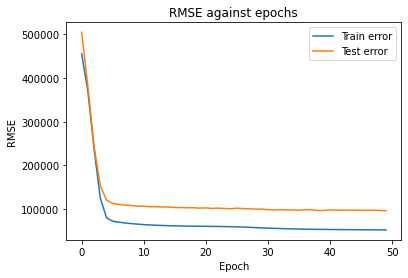

In [41]:
plt.plot(np.sqrt(history.history['loss']))
plt.plot(np.sqrt(history.history['val_loss']))
plt.title('RMSE against epochs')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.legend(['Train error', 'Test error'], loc='upper right')

#plt.savefig('Part 1b Q2(d) rsme.png')

### Part e

Using the model from the best epoch, report the test R^2 value and show the top 30 test samples with the largest errors. List down any trends you find in
these samples and suggest ways to reduce these errors.

(Tip: Add the prediction error as a column in the DataFrame and sort by it.)

In [42]:
find_r2 = best_model.evaluate(test_ds)

print("R Squared Error: " + str(find_r2[1]))

180/180 [==============================] - 1s 4ms/step - loss: 10487806976.0000 - r2: 0.6153 - accuracy: 0.0000e+00
R Squared Error: 0.6152568459510803


In [43]:
predictions = best_model.predict(test_ds)

print(predictions)

C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\functional.py:637: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


180/180 [==============================] - 1s 4ms/step
[[392939.84]
 [543758.06]
 [323566.44]
 ...
 [353213.4 ]
 [222754.78]
 [489824.94]]


In [44]:
# append to dataframe
pd.set_option('display.float_format', lambda x: '%.3f' % x)
test_dataframe["predicted"] = predictions

<ipython-input-44-7ffd4fd45c45>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_dataframe["predicted"] = predictions


In [45]:
# get error 
test_dataframe["error"] = abs(test_dataframe["predicted"] - test_dataframe["resale_price"])

# sort by error
test_dataframe.sort_values(by=['error'], inplace=True, ascending=False)

<ipython-input-45-987e31f29704>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_dataframe["error"] = abs(test_dataframe["predicted"] - test_dataframe["resale_price"])
<ipython-input-45-987e31f29704>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_dataframe.sort_values(by=['error'], inplace=True, ascending=False)


In [46]:
test_dataframe.head(30)

,month,year,full_address,nearest_stn,dist_to_nearest_stn,dist_to_dhoby,degree_centrality,eigenvector_centrality,flat_model_type,remaining_lease_years,floor_area_sqm,storey_range,resale_price,predicted,error
127225,7,2022,92 DAWSON ROAD,Queenstown,0.585,3.882,0.017,0.008,"5 ROOM, Premium Apartment Loft",92.833,122.000,37 TO 39,1418000.000,334620.219,1083379.781
106700,9,2021,273A BISHAN STREET 24,Bishan,0.767,6.328,0.034,0.016,"5 ROOM, DBSS",89.000,120.000,37 TO 39,1295000.000,222444.297,1072555.703
120285,2,2022,1B CANTONMENT ROAD,Outram Park,0.353,2.413,0.034,0.121,"5 ROOM, Type S2",87.917,107.000,46 TO 48,1308000.000,270878.312,1037121.688
115521,12,2021,92 DAWSON ROAD,Queenstown,0.585,3.882,0.017,0.008,"5 ROOM, Premium Apartment Loft",93.333,122.000,40 TO 42,1328000.000,292705.906,1035294.094
103978,8,2021,275A BISHAN STREET 24,Bishan,0.828,6.370,0.034,0.016,"5 ROOM, DBSS",88.917,120.000,25 TO 27,1280000.000,271589.156,1008410.844
131020,8,2022,139B LORONG 1A TOA PAYOH,Caldecott,0.484,4.157,0.017,0.024,"5 ROOM, DBSS",88.750,114.000,31 TO 33,1265000.000,265653.844,999346.156
118249,6,2022,273B BISHAN STREET 24,Bishan,0.776,6.297,0.034,0.016,"5 ROOM, DBSS",88.250,120.000,25 TO 27,1270000.000,281356.281,988643.719
118240,1,2022,273A BISHAN STREET 24,Bishan,0.767,6.328,0.034,0.016,"5 ROOM, DBSS",88.667,120.000,34 TO 36,1338888.000,355337.031,983550.969
118246,6,2022,275A BISHAN STREET 24,Bishan,0.828,6.370,0.034,0.016,"5 ROOM, DBSS",88.333,120.000,28 TO 30,1310000.000,329211.594,980788.406
119399,5,2022,96A HENDERSON ROAD,Tiong Bahru,0.587,2.933,0.017,0.048,"5 ROOM, Improved",96.083,113.000,40 TO 42,1400000.000,419716.594,980283.406


In [47]:
# trends in these samples

# ways to reduce these errors


## Question 3

Model degradation is a common issue faced when deploying neural network models in the real world. In typical coursework settings, you learn the ropes by experimenting on toy datasets, which only offers a static snapshot of the situation. Real life problems, such as the analysis of factors influencing HDB prices, have new data points coming in daily that might exhibit a different pattern from older data points due to factors such as changes in government policy or market sentiments. In such situations, models trained on older data points that differ greatly from the new data could perform poorly. In the last part of this assignment, we will investigate whether this has happened.

There are 2 datasets to work with: ‘HDB_price_prediction.csv’ and ‘HDB_price_prediction_old.csv’. The latter is a subset of the former: both start from the same date but the latter ends on August 2021 while the former has data until August 2022. Both have the same set of training data (2020 and before) but the test data for the latter (i.e. ‘old test set’) is up till August 2021, while the test set from the former has complete data from 2021, along with data till August 2022 (‘new test set’).

### Part a

Apply your model from Q2d on the ‘old test set’. On the ‘new test set’, split it into 2021 and 2022. For all 3 test sets, report the test R^2 value you obtained.

In [48]:
# # old test set
# old_df = pd.read_csv('./hdb_price_prediction_old.csv')
# old_df

In [49]:
# old data set
old_df = pd.read_csv('hdb_price_prediction_old.csv')
old_df

,month,year,full_address,nearest_stn,dist_to_nearest_stn,dist_to_dhoby,degree_centrality,eigenvector_centrality,flat_model_type,remaining_lease_years,floor_area_sqm,storey_range,resale_price
0,1,2017,406 ANG MO KIO AVENUE 10,Ang Mo Kio,1.007,7.006,0.017,0.006,"2 ROOM, Improved",61.333,44.000,10 TO 12,232000.000
1,1,2017,108 ANG MO KIO AVENUE 4,Ang Mo Kio,1.271,7.984,0.017,0.006,"3 ROOM, New Generation",60.583,67.000,01 TO 03,250000.000
2,1,2017,602 ANG MO KIO AVENUE 5,Yio Chu Kang,1.070,9.091,0.017,0.002,"3 ROOM, New Generation",62.417,67.000,01 TO 03,262000.000
3,1,2017,465 ANG MO KIO AVENUE 10,Ang Mo Kio,0.947,7.520,0.017,0.006,"3 ROOM, New Generation",62.083,68.000,04 TO 06,265000.000
4,1,2017,601 ANG MO KIO AVENUE 5,Yio Chu Kang,1.093,9.130,0.017,0.002,"3 ROOM, New Generation",62.417,67.000,01 TO 03,265000.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
104089,8,2021,710 YISHUN AVENUE 5,Yishun,0.826,14.410,0.017,0.000,"4 ROOM, New Generation",61.750,93.000,07 TO 09,390000.000
104090,8,2021,117 YISHUN RING ROAD,Yishun,1.045,15.215,0.017,0.000,"4 ROOM, Model A",60.917,104.000,07 TO 09,380000.000
104091,8,2021,453 YISHUN STREET 41,Khatib,1.425,13.351,0.017,0.001,"4 ROOM, Model A",91.083,93.000,04 TO 06,433000.000
104092,8,2021,505D YISHUN STREET 51,Khatib,1.260,13.233,0.017,0.001,"4 ROOM, Model A",93.667,93.000,01 TO 03,460000.000


In [50]:
# split data
old_train_df = old_df[old_df['year'] <= 2020]
old_test_df = old_df[old_df['year'] > 2020]

In [51]:
# preprocess data
old_train_ds = dataframe_to_dataset(old_train_df)
old_test_ds = dataframe_to_dataset(old_test_df)

old_train_ds = old_train_ds.batch(256)
old_test_ds = old_test_ds.batch(256)

In [52]:
# # new test set
# new_df = pd.read_csv('./hdb_price_prediction.csv')
# new_df

In [53]:
# new test set
new_df = pd.read_csv('hdb_price_prediction.csv')
new_df

,month,year,full_address,nearest_stn,dist_to_nearest_stn,dist_to_dhoby,degree_centrality,eigenvector_centrality,flat_model_type,remaining_lease_years,floor_area_sqm,storey_range,resale_price
0,1,2017,406 ANG MO KIO AVENUE 10,Ang Mo Kio,1.007,7.006,0.017,0.006,"2 ROOM, Improved",61.333,44.000,10 TO 12,232000.000
1,1,2017,108 ANG MO KIO AVENUE 4,Ang Mo Kio,1.271,7.984,0.017,0.006,"3 ROOM, New Generation",60.583,67.000,01 TO 03,250000.000
2,1,2017,602 ANG MO KIO AVENUE 5,Yio Chu Kang,1.070,9.091,0.017,0.002,"3 ROOM, New Generation",62.417,67.000,01 TO 03,262000.000
3,1,2017,465 ANG MO KIO AVENUE 10,Ang Mo Kio,0.947,7.520,0.017,0.006,"3 ROOM, New Generation",62.083,68.000,04 TO 06,265000.000
4,1,2017,601 ANG MO KIO AVENUE 5,Yio Chu Kang,1.093,9.130,0.017,0.002,"3 ROOM, New Generation",62.417,67.000,01 TO 03,265000.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
133407,6,2022,877 YISHUN STREET 81,Khatib,0.476,12.739,0.017,0.001,"EXECUTIVE, Maisonette",64.583,145.000,07 TO 09,810000.000
133408,1,2022,633 YISHUN STREET 61,Khatib,0.774,13.229,0.017,0.001,"MULTI-GENERATION, Multi Generation",65.000,164.000,04 TO 06,785000.000
133409,2,2022,633 YISHUN STREET 61,Khatib,0.774,13.229,0.017,0.001,"MULTI-GENERATION, Multi Generation",64.917,171.000,04 TO 06,842000.000
133410,2,2022,632 YISHUN STREET 61,Khatib,0.701,13.223,0.017,0.001,"MULTI-GENERATION, Multi Generation",64.750,164.000,10 TO 12,845000.000


In [54]:
# split data
new_2021_df = df[df['year'] == 2021] 
new_2022_df = df[df['year'] == 2022] 

In [55]:
# preprocess data
new_2021_ds = dataframe_to_dataset(new_2021_df)
new_2022_ds = dataframe_to_dataset(new_2022_df)

new_2021_ds = new_2021_ds.batch(256)
new_2022_ds = new_2022_ds.batch(256)

In [56]:
r2_old = best_model.evaluate(old_test_ds)
r2_new_2021 = best_model.evaluate(new_2021_ds)
r2_new_2022 = best_model.evaluate(new_2022_ds)

67/67 [==============================] - 0s 3ms/step - loss: 15644053504.0000 - r2: 0.4498 - accuracy: 0.0000e+00


In [57]:
print("R Squared Error (old): " + str(r2_old[1]))
print("R Squared Error (new 2021): " + str(r2_new_2021[1]))
print("R Squared Error (new 2022): " + str(r2_new_2022[1]))

R Squared Error (old): 0.7735299468040466
R Squared Error (new 2021): 0.7145421504974365
R Squared Error (new 2022): 0.4497981071472168


### Part b

The team that produced the linear regression model shared with you their results (test R^2 values): 0.76 on the old test set, 0.715 when only using 2021
data as test set and 0.464 when only using 2022 data as test set.

In light of this (along with their result in Q1b and your results from Q3a), compare the extent to which model degradation has impacted your model to that of the team’s linear regression model and explain why this has occurred.

In [58]:
# compare the extent to which model degradation impacted model to that of team's linear regression model

# explain why this occurred


### Part c

Model degradation could be caused by various data distribution shifts: covariate shift (features), label shift and/or concept drift (altered relationship between features and labels). Recall that machine learning models generally need the test data distribution to be similar to the training data distribution.

With appropriate plots, visualise the distributions of all the features and labels used by the model. Which variable(s) showed the largest covariate/label shift that might have led to the drop in model performance as seen in Q3b? With these insights, suggest a way to address the problem of model degradation. (Note: Only include plots relevant to your answer. Do not include all plots.)

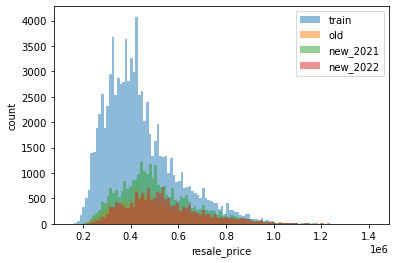

<Figure size 864x576 with 0 Axes>

In [59]:
# distribution for train and test sets
old_train_df["resale_price"].plot.hist(bins=100, alpha=0.5)
old_test_df["resale_price"].plot.hist(bins=100, alpha=0.5)
new_2021_df["resale_price"].plot.hist(bins=100, alpha=0.5)
new_2022_df["resale_price"].plot.hist(bins=100, alpha=0.5)

plt.legend(["train", "old", "new_2021", "new_2022"])
plt.xlabel("resale_price")
plt.ylabel("count")

#show plot
plt.ticklabel_format()
plt.figure(figsize=(12,8))
plt.show()

In [60]:
# comment 


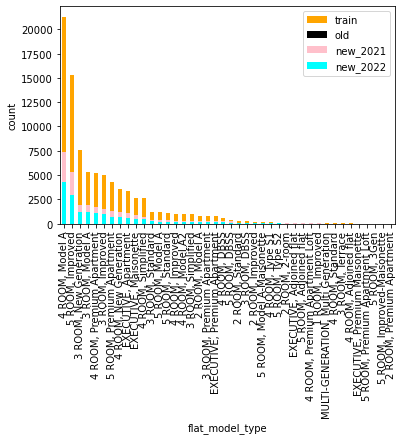

<Figure size 864x576 with 0 Axes>

In [61]:
# distribution for flat_model_type
old_train_df["flat_model_type"].value_counts().plot.bar(color="orange")
old_test_df["flat_model_type"].value_counts().plot.bar(color="black")
new_2021_df["flat_model_type"].value_counts().plot.bar(color="pink")
new_2022_df["flat_model_type"].value_counts().plot.bar(color="cyan")

plt.legend(["train", "old", "new_2021", "new_2022"])
plt.xlabel("flat_model_type")
plt.ylabel("count")

plt.figure(figsize=(12,8))
plt.show()


In [62]:
# comment


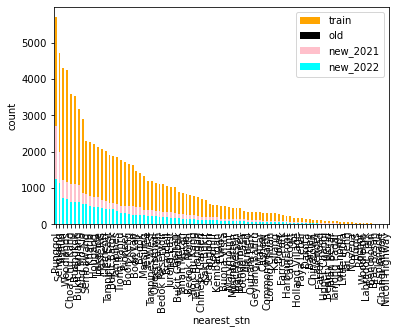

<Figure size 864x576 with 0 Axes>

In [63]:
# distribution for nearest_stn
old_train_df["nearest_stn"].value_counts().plot.bar(color="orange")
old_test_df["nearest_stn"].value_counts().plot.bar(color="black")
new_2021_df["nearest_stn"].value_counts().plot.bar(color="pink")
new_2022_df["nearest_stn"].value_counts().plot.bar(color="cyan")

plt.legend(["train", "old", "new_2021", "new_2022"])
plt.xlabel("nearest_stn")
plt.ylabel("count")

plt.figure(figsize=(12,8))
plt.show()

In [64]:
# comment


In [65]:
# which variable showed largest covariate/label shift that might have led to drop in model performance


In [66]:
# suggest a way to address problem of model degradation


### Part d

The team passed you a script (‘RFE.py’) that recursively removes features from a neural network, so as to find the best feature subset. Run this piece of
code with your model from Q2d and report the best feature subset obtained.

In [67]:
SEED = 42

import os
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

import random 
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)


import time
start = time.time()

num_features = 9

vec = [1 for i in range(num_features)]
best_loss = 1e15
new_best_loss = 1e14
which_iter = ''

all_losses = [] # should be len 9,8,7,...

In [68]:
def train_model(feature_mask, best_neuron, best_divisor, best_learning):
    """
    Given a boolean mask (feature_mask), select the features accordingly, train the model and return the validation loss.
    """
    
    feature_mask_string = ''.join([str(i) for i in feature_mask])
    
    # TODO: define the input layer here (your code from Q2)
    # Categorical features encoded as integers
    month_len = len(np.unique(train_dataframe['month']))
    month = keras.Input(shape=(1,), name="month", dtype="int64")
    month_embedded = embed_categorical_feature(month, "month", train_ds, False, month_len, best_divisor)

    # Categorical feature encoded as string
    flat_model_type_len = len(np.unique(train_dataframe['flat_model_type']))
    flat_model_type = keras.Input(shape=(1,), name="flat_model_type", dtype="string")
    flat_model_type_embedded = embed_categorical_feature(flat_model_type, "flat_model_type", train_ds, True, flat_model_type_len, best_divisor)

    storey_range_len = len(np.unique(train_dataframe['storey_range']))
    storey_range = keras.Input(shape=(1,), name="storey_range", dtype="string")
    storey_range_embedded = embed_categorical_feature(storey_range, "storey_range", train_ds, True, storey_range_len, best_divisor)

    # Numerical features
    floor_area_sqm = keras.Input(shape=(1,), name="floor_area_sqm")
    floor_area_sqm_encoded = encode_numerical_feature(floor_area_sqm, "floor_area_sqm", train_ds)

    remaining_lease_years = keras.Input(shape=(1,), name="remaining_lease_years")
    remaining_lease_years_encoded = encode_numerical_feature(remaining_lease_years, "remaining_lease_years", train_ds)

    eigenvector_centrality = keras.Input(shape=(1,), name="eigenvector_centrality")
    eigenvector_centrality_encoded = encode_numerical_feature(eigenvector_centrality, "eigenvector_centrality", train_ds) 

    degree_centrality = keras.Input(shape=(1,), name="degree_centrality")
    degree_centrality_encoded = encode_numerical_feature(degree_centrality, "degree_centrality", train_ds)

    dist_to_dhoby = keras.Input(shape=(1,), name="dist_to_dhoby")
    dist_to_dhoby_encoded = encode_numerical_feature(dist_to_dhoby, "dist_to_dhoby", train_ds)

    dist_to_nearest_stn = keras.Input(shape=(1,), name="dist_to_nearest_stn")
    dist_to_nearest_stn_encoded = encode_numerical_feature(dist_to_nearest_stn, "dist_to_nearest_stn", train_ds)

    all_inputs = [
        dist_to_nearest_stn,
        dist_to_dhoby,
        degree_centrality,
        eigenvector_centrality,
        remaining_lease_years,
        floor_area_sqm,
        month,
        flat_model_type,
        storey_range
    ]

    all_features_input = [
            month_embedded,
            flat_model_type_embedded,
            floor_area_sqm_encoded,
            storey_range_embedded,
            remaining_lease_years_encoded,
            eigenvector_centrality_encoded,
            degree_centrality_encoded,
            dist_to_dhoby_encoded,
            dist_to_nearest_stn_encoded        
      ]


    selected_inputs = []
    print('going through feature_mask', feature_mask)
    for i,j in zip(all_features_input, feature_mask):
        if j == 1:
            selected_inputs.append(i)
            print(i)
        else:
            print('Skipping', i)

    all_features = layers.concatenate(selected_inputs)
    
    # TODO: Complete the rest of the architecture + training code and retrieve the training history
    # setup parameters
    opt_ = tf.keras.optimizers.Adam(learning_rate=best_learning)
    epochs_ = 50
    batch_ = 256

    # define model
    x_ = layers.Dense(best_neuron, activation="relu")(all_features)
    output_ = layers.Dense(1, activation="linear")(x_)
    model_ = keras.Model(all_inputs, output_)

    # compile model
    model_.compile(optimizer=opt_, loss='mse', metrics=[r2])

    # fit model
    history_ = model_.fit(train_ds, epochs=epochs_, validation_data=val_ds, batch_size=batch_, verbose=2)

    val_loss_hx = history_.history['val_loss'] # NOTE: You can use RMSE if you find it easier to interpret.
    val_loss_min = min(val_loss_hx)
    
    return val_loss_min

In [69]:
## RFE starts here 
while sum(vec) > 0 and best_loss > new_best_loss:
    
    print('vec', vec)

    best_loss = new_best_loss
    new_min_loss_flag = False
    
    losses_from_same_vec = []
    
    for ix, i in enumerate(vec):
        
        print('ix', ix, 'i', i)
        
        if i == 0:
            continue # if the feature is off, no need to do anything, go to next position
        else:
            temp_vec = vec[:]
            temp_vec[ix] = 0 # turn off the feature
            print('updated temp_vec', temp_vec)
            
            loss = train_model(temp_vec, best_neuron, best_divisor, best_learning)
            losses_from_same_vec.append(loss)
            
            if loss < new_best_loss:
                new_best_loss = loss
                which_iter = 'len ' + str(sum(vec)) + ', ix ' + str(ix)
                print('new min loss:', which_iter)
                new_min_loss_flag = True
                min_loss_vec = temp_vec[:]

            tf.keras.backend.clear_session()
            print('session cleared!\n')
                
    
    all_losses.append(losses_from_same_vec)
    
    # After going through the vec once, update vec if new min loss    
    if new_min_loss_flag:
        vec = min_loss_vec
    
    # else case means no new min loss, the latter while loop condition will cause it to terminate 
    print(time.time() - start, 'seconds elapsed')
    print()

vec [1, 1, 1, 1, 1, 1, 1, 1, 1]
ix 0 i 1
updated temp_vec [0, 1, 1, 1, 1, 1, 1, 1, 1]
going through feature_mask [0, 1, 1, 1, 1, 1, 1, 1, 1]
Skipping KerasTensor(type_spec=TensorSpec(shape=(None, 12), dtype=tf.float32, name=None), name='flatten_3/Reshape:0', description="created by layer 'flatten_3'")
KerasTensor(type_spec=TensorSpec(shape=(None, 41), dtype=tf.float32, name=None), name='flatten_4/Reshape:0', description="created by layer 'flatten_4'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='normalization_6/truediv:0', description="created by layer 'normalization_6'")
KerasTensor(type_spec=TensorSpec(shape=(None, 17), dtype=tf.float32, name=None), name='flatten_5/Reshape:0', description="created by layer 'flatten_5'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='normalization_7/truediv:0', description="created by layer 'normalization_7'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.floa

C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\functional.py:637: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


251/251 - 4s - loss: 75463311360.0000 - r2: -2.1944e+00 - val_loss: 10334036992.0000 - val_r2: 0.5634 - 4s/epoch - 15ms/step
Epoch 2/50
251/251 - 2s - loss: 9070600192.0000 - r2: 0.6152 - val_loss: 8755932160.0000 - val_r2: 0.6311 - 2s/epoch - 8ms/step
Epoch 3/50
251/251 - 2s - loss: 8159265792.0000 - r2: 0.6524 - val_loss: 8272871424.0000 - val_r2: 0.6506 - 2s/epoch - 9ms/step
Epoch 4/50
251/251 - 2s - loss: 7729560576.0000 - r2: 0.6711 - val_loss: 7987307008.0000 - val_r2: 0.6598 - 2s/epoch - 7ms/step
Epoch 5/50
251/251 - 2s - loss: 7374686208.0000 - r2: 0.6864 - val_loss: 7645968896.0000 - val_r2: 0.6749 - 2s/epoch - 7ms/step
Epoch 6/50
251/251 - 2s - loss: 7023542784.0000 - r2: 0.7012 - val_loss: 7267692544.0000 - val_r2: 0.6931 - 2s/epoch - 7ms/step
Epoch 7/50
251/251 - 2s - loss: 6650627072.0000 - r2: 0.7170 - val_loss: 6995680768.0000 - val_r2: 0.7063 - 2s/epoch - 7ms/step
Epoch 8/50
251/251 - 2s - loss: 6278251008.0000 - r2: 0.7322 - val_loss: 6353241088.0000 - val_r2: 0.7333 -

In [70]:
print(all_losses)

[[3831674112.0, 3492169984.0, 3478057728.0, 4627110400.0, 4898845184.0, 3847911936.0, 3988491776.0, 6490211840.0, 4435342336.0], [4205661184.0, 15844008960.0, 4932816896.0, 4880065536.0, 4193671424.0, 4287794944.0, 6753583104.0, 4788743168.0]]


In [71]:
# best feature subset obtained


### Part e

RFE on the ‘old test set’ eliminated features degree_centrality and month. It also showed that dist_to_dhoby and dist_to_nearest_stn are crucial (removing
them leads to higher test loss). Compare these features to those in Q3d and
discuss whether concept drift has occurred.

In [72]:
# compare to those in Q3d

# discuss whether concept drift occurred


## Conclusion

Possible discussion pointers for conclusion:

Besides the discussion pointers mentioned in Part A,

*   In Q1, we compared a linear regression model to an equivalent neural network architecture and also saw how adding a hidden layer changes model performance. In Q2, we saw how adding an Embedding layer introduces more learnable parameters to the neural network. What other benefits do neural networks have over other machine learning approaches? In cases where neural networks perform better, is it possible to modify ‘traditional’ machine learning algorithms to close up the gap?
*   In Q2, we tried out another approach of model tuning. KerasTuner offers many other algorithms – how do Bayesian optimisation or HyperBand work? Are they necessarily better than random search? Also, is random search better than grid search?
*   In Q3, we witnessed what happened to machine learning models if they are not updated with the latest datasets and looked at whether covariate shift, label shift or concept drift has occurred. Which of these have led to model degradation? Was the change in LTV ratio the cause of it (if so, how did it affect the model performance)?
*   You do not have to answer all the above discussion pointers. You can choose to deep dive into one of it and write a paragraph or two to summarise your thoughts + reflect on what you have learnt from this part of the assignment.
*   Feel free to include your own pointers, as long as they are within the scope of Part B. For instance, we see that the RMSE is still rather high – what else can we do to reduce it? There are many possible extensions to the current model especially because we are limited to using vanilla neural networks for this assignment.